In [1]:
from fgbuster import harmonic_ilc_alm,CMB
import healpy as hp
import pysm3
import pysm3.units as u
import sys
import curvedsky as cs
import cmb
import os
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('../')
from utils import camb_clfile,cli
import mpi
import matplotlib.pyplot as plt
import pickle as pl
from database import surveys,noise

In [2]:
infolder = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/'
dnside = 512
lmax = 3*dnside -1
maskpath = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits'
cl_lenf = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
cl_len = cmb.read_camb_cls(cl_lenf,ftype='lens',output='array')[:,:lmax+1]
mydir = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/HILC_debug'
os.makedirs(mydir,exist_ok=True)

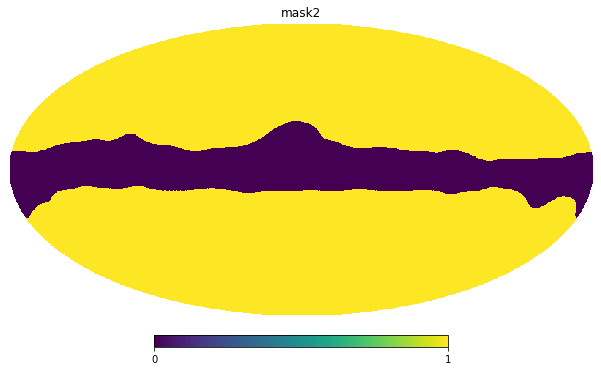

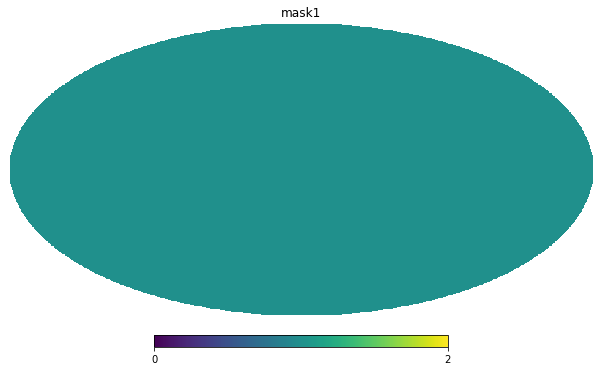

In [3]:
mask1 = np.ones(hp.nside2npix(dnside),dtype=int)
mask2 = hp.ud_grade(hp.read_map(maskpath),dnside)
hp.mollview(mask2,title='mask2')
hp.mollview(mask1,title='mask1')

In [4]:
class INST:
    def __init__(self,beam,frequency):
        self.Beam = beam
        self.fwhm = beam
        self.frequency = frequency
        
def get_cmb():
    idx = 0
    fname = os.path.join(infolder,f"cmb_sims_{idx:04d}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def get_fg(v):
    fname = os.path.join(fg_dir,f"{fg_str}_{int(v)}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def cmb_fg(v):
    fname = os.path.join(mydir,f'total_{int(v)}.fits')
    if os.path.isfile(fname):
        return hp.read_map(fname,(0,1,2))
    else:
        maps = get_cmb() + get_fg(v)
        hp.write_map(fname,maps)
        return maps


def get_noise_spectra(depth_i,depth_p):
    t = np.ones(lmax+1)*(np.radians(depth_i/60)**2)
    e = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    b = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    return t,e,b

def get_noise_alm(depth_i,depth_p):
    t,e,b = get_noise_spectra(depth_i,depth_p)
    t = hp.synalm(t,lmax=lmax)
    e = hp.synalm(e,lmax=lmax)
    b = hp.synalm(b,lmax=lmax)
    return t,e,b


def get_noise_map1(v,depth_i,depth_p):
    fname = os.path.join(mydir,f'noise_{int(v)}_v1.fits')
    if os.path.isfile(fname):
        return hp.read_map(fname,(0,1,2))
    else:
        t,e,b = get_noise_alm(depth_i,depth_p)
        maps =  hp.alm2map([t,e,b],nside=dnside)
        hp.write_map(fname,maps)
        return maps
def get_noise_map2(v,depth_i,depth_p):
    depth_i = np.array([depth_i])
    depth_p = np.array([depth_p])
    fname = os.path.join(mydir,f'noise_{int(v)}_v2.fits')
    if os.path.isfile(fname):
        return hp.read_map(fname,(0,1,2))
    else:
        pix_amin2 = 4. * np.pi / float(hp.nside2npix(dnside)) * (180. * 60. / np.pi) ** 2
        """sigma_pix_I/P is std of noise per pixel. It is an array of length
        equal to the number of input maps."""
        sigma_pix_I = np.sqrt(depth_i ** 2 / pix_amin2)
        sigma_pix_P = np.sqrt(depth_p ** 2 / pix_amin2)
        npix = hp.nside2npix(dnside)
        noise = np.random.randn(len(depth_i), 3, npix)
        noise[:, 0, :] *= sigma_pix_I[:, None]
        noise[:, 1, :] *= sigma_pix_P[:, None]
        noise[:, 2, :] *= sigma_pix_P[:, None]
        noise = noise[0]
        hp.write_map(fname,noise)
        return noise

def get_noise_map(v,depth_i,depth_p,which=2):
    if which == 1:
        return get_noise_map1(v,depth_i,depth_p)
    else:
        return get_noise_map2(v,depth_i,depth_p)


def get_exp_maps(v,depth_i,depth_p,beam):
    bl = hp.gauss_beam(np.radians(45/60),lmax=lmax, pol=True).T
    fl = hp.gauss_beam(np.radians(beam/60),lmax=lmax, pol=True).T
    maps = hp.smoothing(cmb_fg(v),fwhm=np.radians(beam/60)) + get_noise_map(v,depth_i,depth_p)
    alms = hp.map2alm(maps)
    hp.almxfl(alms[0],cli(fl[0]),inplace=True)
    hp.almxfl(alms[1],cli(fl[1]),inplace=True)
    hp.almxfl(alms[2],cli(fl[2]),inplace=True)
    hp.almxfl(alms[0],bl[0],inplace=True)
    hp.almxfl(alms[1],bl[1],inplace=True)
    hp.almxfl(alms[2],bl[2],inplace=True)
    return alms



def get_exp_arr(v,n_t,n_p,beam,which=1):
        arr = []
        for i in tqdm(range(len(v)),desc="Making map",unit='Freq'):
            if which == 1:
                arr.append(get_exp_maps(v[i],n_t[i],n_p[i],beam[i]))
            else:
                raise ValueError
        return np.array(arr)

def apply_harmonic_W(W,  # (..., ell, comp, freq)
                      alms):  # (freq, ..., lm)
    lmax = hp.Alm.getlmax(alms.shape[-1])
    res = np.full((W.shape[-2],) + alms.shape[1:], np.nan, dtype=alms.dtype)
    start = 0
    for i in range(0, lmax+1):
        n_m = lmax + 1 - i
        res[..., start:start+n_m] = np.einsum('...lcf,f...l->c...l',
                                              W[..., i:, :, :],
                                              alms[..., start:start+n_m])
        start += n_m
    return res


In [5]:
sigma = 2.16
Tcmb  = 2.726e6
invn1 = mask1 * (np.radians(sigma/60)/Tcmb)**-2
invN1 = np.reshape(np.array((invn1,invn1)),(2,1,hp.nside2npix(dnside)))
invn2 = mask2 * (np.radians(sigma/60)/Tcmb)**-2
invN2 = np.reshape(np.array((invn2,invn2)),(2,1,hp.nside2npix(dnside)))
fg_dir = '/global/cscratch1/sd/lonappan/S4BIRD/FG'
fg_str = "s0d0"

In [6]:
table = surveys().get_table_dataframe("LITEBIRD_V1")
table = table[table.frequency > 70]
exp_freqs = np.array(table.frequency)
exp_beam = np.array(table.fwhm)
exp_nlev_p = np.array(table.depth_p)
exp_nlev_t = exp_nlev_p/np.sqrt(2)

In [7]:
list(table.fwhm)

[43.8, 41.5, 37.8, 33.6, 30.8, 28.9, 28.6, 24.7, 22.5, 20.9, 17.9]

In [8]:
instrument = INST(None,exp_freqs)
components = [CMB()]
bins = np.arange(1000) * 10

In [9]:
alms= get_exp_arr(exp_freqs,exp_nlev_t,exp_nlev_p,exp_beam)

Making map: 100%|██████████| 11/11 [05:11<00:00, 28.32s/Freq]


In [10]:
result = harmonic_ilc_alm(components, instrument,alms,bins)

In [11]:
TEB = [result.s[0,0],result.s[0,1],result.s[0,2]]

(1e-13, 50535.09631654591)

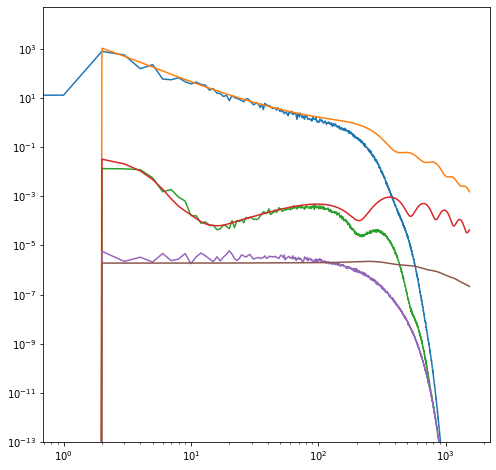

In [37]:
plt.figure(figsize=(8,8))
plt.loglog(hp.alm2cl(TEB[0]),label='T')
plt.loglog(cl_len[0,:]*Tcmb**2,label='T')
plt.loglog(hp.alm2cl(TEB[1]),label='E')
plt.loglog(cl_len[1,:]*Tcmb**2,label='E')
plt.loglog(hp.alm2cl(TEB[2]),label='B')
plt.loglog(cl_len[2,:]*Tcmb**2,label='B')
plt.ylim(10**-13,None)

In [13]:
w = result.W

In [14]:
noise_alm_arr = []
for v,n_t,n_p in zip(exp_freqs,exp_nlev_t,exp_nlev_p):
    noise_alm_arr.append(hp.map2alm(get_noise_map(v,n_t,n_p)))

In [15]:
nlm = apply_harmonic_W(w,np.array(noise_alm_arr))[0]

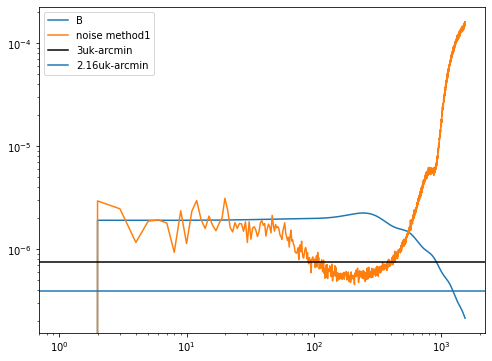

In [16]:
plt.figure(figsize=(8,6))
plt.loglog(cl_len[2,:]*Tcmb**2,label='B')
plt.loglog(hp.alm2cl(nlm[2]),label='noise method1')
plt.axhline(np.radians(3/60)**2,c='k',label='3uk-arcmin')
plt.axhline(np.radians(2.16/60)**2,label='2.16uk-arcmin')
plt.legend()

In [17]:
Nl_P = []
B_P = []
for b,n in zip(exp_beam,np.radians(exp_nlev_p/60)**2):
    B_P.append(hp.gauss_beam(np.radians(b/60),lmax=lmax))
    Nl_P.append(np.ones(lmax+1)*n)
Nl_P = np.array(Nl_P)
B_P = np.array(B_P)

In [18]:
w_bb = result.W[2]
nl_bb = np.zeros(lmax+1)
bl_bb = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_bb[i] = np.dot(Nl_P[:, i], w_bb[i][0]**2)
for i in range(lmax+1):
    bl_bb[i] = np.dot(B_P[:, i], w_bb[i][0])
    

w_ee = result.W[1]
nl_ee = np.zeros(lmax+1)
bl_ee = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_ee[i] = np.dot(Nl_P[:, i], w_ee[i][0]**2)
for i in range(lmax+1):
    bl_ee[i] = np.dot(B_P[:, i], w_ee[i][0])

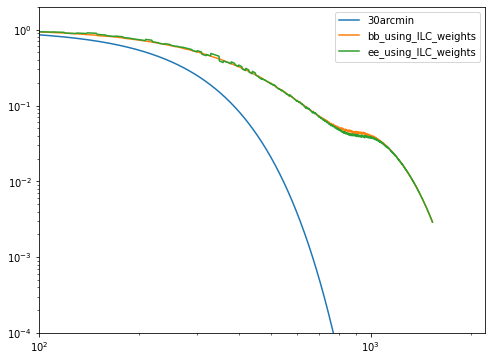

In [19]:
plt.figure(figsize=(8,6))
plt.loglog(hp.gauss_beam(np.radians(45/60),lmax=lmax),label='30arcmin')
plt.loglog(bl_bb,label='bb_using_ILC_weights')
plt.loglog(bl_ee,label='ee_using_ILC_weights')
plt.ylim(1e-4,2)
plt.xlim(100,None)
plt.legend()

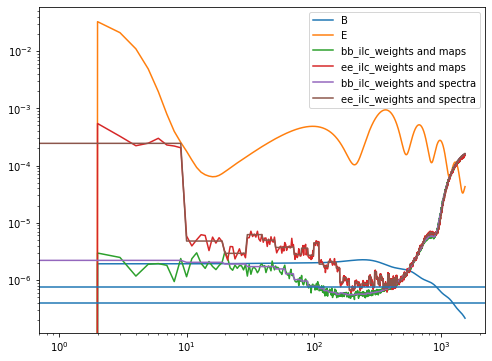

In [38]:
plt.figure(figsize=(8,6))
plt.loglog(cl_len[2,:]*Tcmb**2,label='B')
plt.loglog(cl_len[1,:]*Tcmb**2,label='E')
plt.loglog(hp.alm2cl(nlm[2]),label='bb_ilc_weights and maps')
plt.loglog(hp.alm2cl(nlm[1]),label='ee_ilc_weights and maps')
plt.loglog(nl_bb,label='bb_ilc_weights and spectra')
plt.loglog(nl_ee,label='ee_ilc_weights and spectra')
plt.axhline(np.radians(3/60)**2)
plt.axhline(np.radians(2.16/60)**2)
plt.legend()

In [21]:
TQU = hp.alm2map(TEB,dnside)

In [22]:
QU1 = np.reshape(np.array((TQU[1],TQU[2])),(2,1,hp.nside2npix(dnside)))/Tcmb
QU2 = np.reshape(np.array((TQU[1]*mask2,TQU[2]*mask2)),(2,1,hp.nside2npix(dnside)))/Tcmb

In [23]:
Bl = np.reshape(hp.gauss_beam(np.radians(45/60),lmax=lmax),(1,lmax+1))

In [24]:
E_2p16_1,B_2p16_1 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN1,QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')


In [25]:
E_2p16_2,B_2p16_2 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN2,QU2,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

In [26]:
wofg_bl = hp.gauss_beam(np.radians(45/60),lmax=lmax)
wofg_Bl = np.reshape(wofg_bl,(1,lmax+1))

ntt = np.ones(lmax+1)  * np.radians(1.5/60)**2
npp = np.ones(lmax+1)  * np.radians(2.16/60)**2

wofg_N = hp.synfast([ntt,npp,npp,npp*0],dnside)

In [27]:
maps = wofg_N + hp.smoothing(get_cmb(),fwhm=np.radians(45/60))
alms = hp.map2alm(maps)
hp.almxfl(alms[0],cli(bl_bb),inplace=True)
hp.almxfl(alms[1],cli(bl_bb),inplace=True)
hp.almxfl(alms[2],cli(bl_bb),inplace=True)
hp.almxfl(alms[0],bl_bb,inplace=True)
hp.almxfl(alms[1],bl_bb,inplace=True)
hp.almxfl(alms[2],bl_bb,inplace=True)

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -5.17976575e-04+0.00000000e+00j, ...,
        5.72833081e-19-2.41034446e-19j, -3.83083291e-19-4.70289604e-19j,
       -3.67444329e-19+6.46427679e-20j])

In [28]:
TQU_wofg = hp.alm2map(alms,dnside)

In [29]:
QU_wofg = np.reshape(np.array((TQU_wofg[1],TQU_wofg[2])),(2,1,hp.nside2npix(dnside)))/Tcmb

In [30]:
E_wofg,B_wofg =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],wofg_Bl,invN1,QU_wofg,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

/tmp/ipykernel_34925/2056172833.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


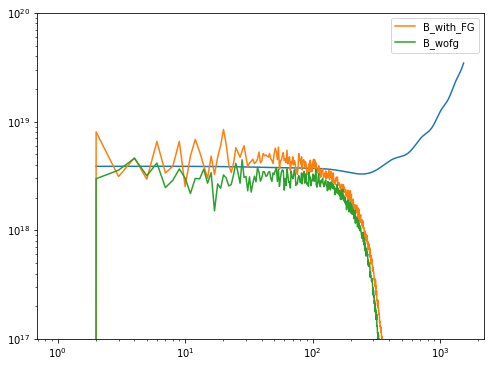

In [40]:
plt.figure(figsize=(8,6))
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B_2p16_1),label='B_with_FG')
#plt.loglog(cs.utils.alm2cl(lmax,B_2p16_2)/.8,label='B_2p16_2')
plt.loglog(cs.utils.alm2cl(lmax,B_wofg)/.8,label='B_wofg')
plt.ylim(1e17,1e20)
plt.legend()

In [32]:
NL = np.reshape(np.array((cli(nl_ee[:lmax+1]/Tcmb**2),cli(nl_bb[:lmax+1]/Tcmb**2))),(2,1,lmax+1))

In [33]:
E_2p16_1_nl, B_2p16_1_nl = cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,
                                                  np.reshape(np.array((mask1,mask1)),(2,1,hp.nside2npix(dnside))),
                                                  QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt',inl=NL)

In [34]:
E_2p16_2_nl, B_2p16_2_nl = cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,
                                                  np.reshape(np.array((mask2,mask2)),(2,1,hp.nside2npix(dnside))),
                                                  QU2,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt',inl=NL)

/tmp/ipykernel_34925/201479088.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


(1e+17, 1e+20)

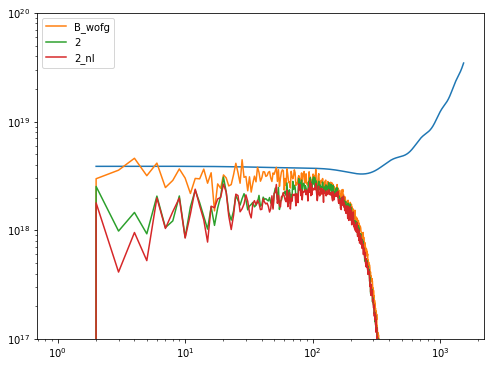

In [35]:
plt.figure(figsize=(8,6))
plt.loglog(1/cl_len[2,:])

plt.loglog(cs.utils.alm2cl(lmax,B_wofg)/.8,label='B_wofg')
plt.loglog(cs.utils.alm2cl(lmax,B_2p16_1_nl),label='2')
plt.loglog(cs.utils.alm2cl(lmax,B_2p16_2_nl)/.8,label='2_nl')
plt.legend()
plt.ylim(1e17,1e20)

/tmp/ipykernel_34925/2238159217.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,B_2p16_2_nl)/cs.utils.alm2cl(lmax,B_wofg))
/tmp/ipykernel_34925/2238159217.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,B_2p16_2)/cs.utils.alm2cl(lmax,B_wofg))


(0.0, 1.5)

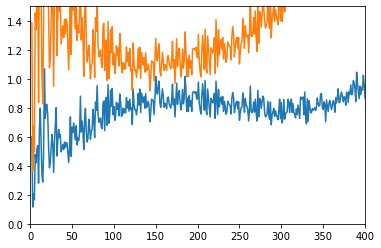

In [36]:
plt.plot(cs.utils.alm2cl(lmax,B_2p16_2_nl)/cs.utils.alm2cl(lmax,B_wofg))
plt.plot(cs.utils.alm2cl(lmax,B_2p16_2)/cs.utils.alm2cl(lmax,B_wofg))
plt.xlim(0,400)
plt.ylim(0,1.5)